# Qubism visualizations

by [Piotr Migdał](http://migdal.wikidot.com/), June 2014

For more information about QuTiP see http://qutip.org.

For more information about Qubism see:
* J. Rodriguez-Laguna, P. Migdał, M. Ibanez Berganza, M. Lewenstein, G. Sierra,
  [Qubism: self-similar visualization of many-body wavefunctions](http://dx.doi.org/10.1088/1367-2630/14/5/053028), New J. Phys. 14 053028 (2012), [arXiv:1112.3560](http://arxiv.org/abs/1112.3560),
* [its video abstract](https://www.youtube.com/watch?v=8fPAzOziTZo),
* [C++ and Mathematica code on GitHub](https://github.com/stared/qubism).

This note describes plotting functions `plot_schmidt` and `plot_qubism`, and additionally - `complex_array_to_rgb`, along with their applications.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Qobj, about, complex_array_to_rgb, jmat, ket, plot_qubism,
                   plot_schmidt, qeye, sigmax, sigmay, sigmaz, tensor)

%matplotlib inline

## Colors

In quantum mechanics, complex numbers are as natual as real numbers.

Before going into details of particular plots, we show how `complex_array_to_rgb` maps $z = x + i y$ into colors.
There are two variants, `theme='light'` and `theme='dark'`. For both, we use hue for phase, with red for positive numbers and aqua for negative.

For a longer comment on coloring complex functions I recommend IPython Notebook [Visualizing complex-valued functions with Matplotlib and Mayavi](http://nbviewer.ipython.org/github/empet/Math/blob/master/DomainColoring.ipynb) by Emilia Petrisor.

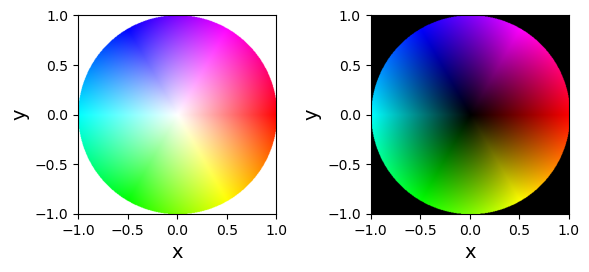

In [2]:
compl_circ = np.array(
    [
        [(x + 1j * y) if x ** 2 + y**2 <= 1 else 0j
            for x in np.arange(-1, 1, 0.005)]
        for y in np.arange(-1, 1, 0.005)
    ]
)

fig = plt.figure(figsize=(6, 3))
for i, theme in enumerate(["light", "dark"]):
    ax = plt.subplot(1, 2, i + 1)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.imshow(
        complex_array_to_rgb(compl_circ, rmax=1, theme=theme),
        extent=(-1, 1, -1, 1)
    )
plt.tight_layout()

## Schmidt plot

Arguably, the easiest way to show entanglement is to plot a wavefunction against two variables.
If the plot is a product of them, the state is a product state. If not - it is entangled.

As writing a wavefunction as a matrix $|\psi\rangle_{ij}$ is the the crucial step in [Schmidt decomposition](http://en.wikipedia.org/wiki/Schmidt_decomposition),
we call such plots Schmidt plots.

Let us consider two states:

* entangled: singlet state $|\psi^-\rangle = (|01\rangle - |10\rangle)/\sqrt{2}$,
* product $(|01\rangle - |00\rangle)/\sqrt{2}$.

They may look seamingly similar, but the later can be decomposed into a product $|0\rangle(|1\rangle - |0\rangle)/\sqrt{2}$.

In [3]:
singlet = (ket("01") - ket("10")).unit()
separable = (ket("01") - ket("00")).unit()

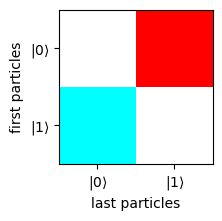

In [4]:
plot_schmidt(singlet, figsize=(2, 2));

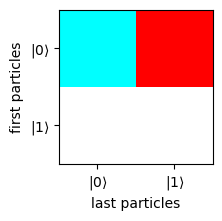

In [5]:
plot_schmidt(separable, figsize=(2, 2));

As we see, for separable state the plot is a product of `x` and `y` coordinates, while for the singlet state - is is not.

Let us now consider a product of two singlet states: $|\psi^-\rangle|\psi^-\rangle$.
Schmidt plot, by default, makes spliting of equal numbers of particles.

(And just for fun, let's multiply it by the imaginary unit, to get diffeerent colors.)

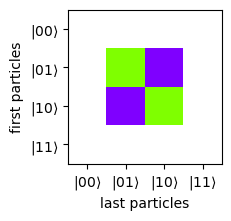

In [6]:
plot_schmidt(1j * tensor([singlet, singlet]), figsize=(2, 2));

As we see, we have a product, as the state is a product state with the respect to the splitting of first 2 vs last 2 particles.

But what if we shift particles, getting $|\psi^-\rangle_{23}|\psi^-\rangle_{41}$?

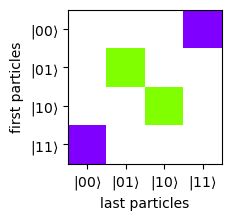

In [7]:
plot_schmidt(1j * tensor([singlet, singlet]).permute([1, 2, 3, 0]),
             figsize=(2, 2));

So we see that it is entangled.

`plot_schmidt` allows us to specify other splittings. With parameter `splitting` we decide how many particles we want to have as columns. In general, we can plot systems of various numbers of particles, each being of a different dimension.

For example:

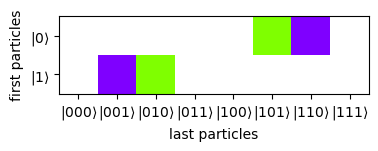

In [8]:
plot_schmidt(
    1j * tensor([singlet, singlet]),
    splitting=1,
    labels_iteration=(1, 3),
    figsize=(4, 2),
);

## Qubism plot

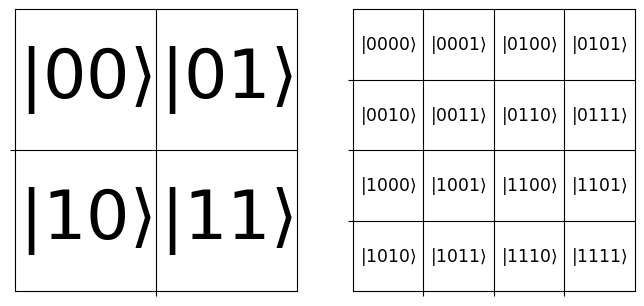

In [9]:
fig = plt.figure(figsize=(8, 4))
for i in [1, 2]:
    ax = plt.subplot(1, 2, i)
    plot_qubism(0 * ket("0000"), legend_iteration=i, grid_iteration=i,
                fig=fig, ax=ax)

That is, all amplitudes for states starting with:

* $|00\rangle$ go to the upper left quadrant,
* $|01\rangle$ go to the upper right quadrant,
* $|10\rangle$ go to the lower left quadrant,
* $|11\rangle$ go to the lower right quadrant.

And we proceed recursively with the next particles. So, for example:

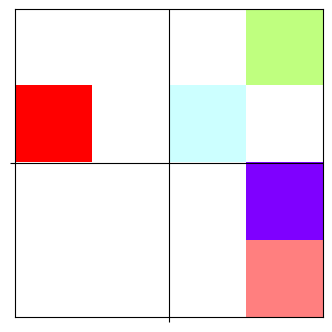

In [10]:
state = (
    ket("0010")
    + 0.5 * ket("1111")
    + 0.5j * ket("0101")
    - 1j * ket("1101")
    - 0.2 * ket("0110")
)
plot_qubism(state, figsize=(4, 4));

Or if we want to make sure how did we map amplitudes to particular regions in the plot:

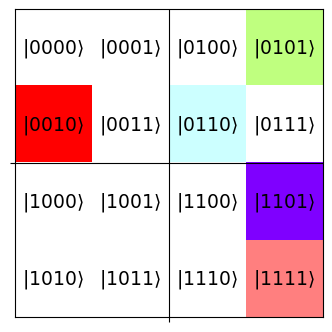

In [11]:
plot_qubism(state, legend_iteration=2, figsize=(4, 4));

Or how about making it dark? (E.g. to fit out slides with black background).

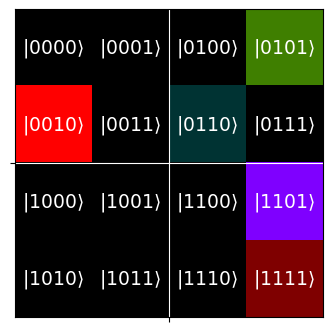

In [12]:
plot_qubism(state, legend_iteration=2, theme="dark", figsize=(4, 4));

The most important property of Qubism is the recursive structure. So that we can add more particles seamlessly.
For example, let's consider a plot of `k` copies of the singlet states, i.e. $|\psi^-\rangle^{\otimes k}$:

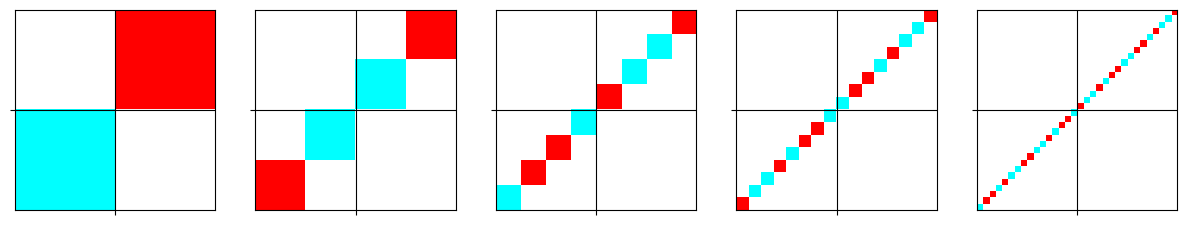

In [13]:
fig = plt.figure(figsize=(15, 3))
for k in range(1, 6):
    ax = plt.subplot(1, 5, k)
    plot_qubism(tensor([singlet] * k), fig=fig, ax=ax)

OK, but once we can type the wavefunction by hand, plots offer little added value.

Let's see how we can plot ground states.
Before doing that, we define some functions to easy make a translationally-invariant Hamiltonian.

In [14]:
def spinchainize(op, n, bc="periodic"):

    if isinstance(op, list):
        return sum([spinchainize(each, n, bc=bc) for each in op])

    k = len(op.dims[0])
    d = op.dims[0][0]

    expanded = tensor([op] + [qeye(d)] * (n - k))

    if bc == "periodic":
        shifts = n
    elif bc == "open":
        shifts = n - k + 1

    shifteds = [
        expanded.permute([(i + j) % n for i in range(n)])
        for j in range(shifts)
    ]

    return sum(shifteds)


def gs_of(ham):
    gval, gstate = ham.groundstate()
    return gstate

For example, let us consider Hamiltonian for $N$ particles, of the following form (a generalization of the [Majumdar-Ghosh model](http://en.wikipedia.org/wiki/Majumdar%E2%80%93Ghosh_Model)):

$$H = \sum_{i=1}^N \vec{S}_i \cdot \vec{S}_{i+1} + J \sum_{i=1}^N \vec{S}_i \cdot \vec{S}_{i+2},$$

where $\vec{S}_i = \tfrac{1}{2} (\sigma^x, \sigma^y, \sigma^z)$ is the spin operator (with sigmas being [Pauli matrices](http://en.wikipedia.org/wiki/Pauli_matrices)).

Moreover, we can set two different boundary conditions:

* periodic - spin chain forms a loop ($N+1 \equiv 1$ and $N+2 \equiv 2$),
* open - spin chain forms a line (we remove terms with $N+1$ and $N+2$).

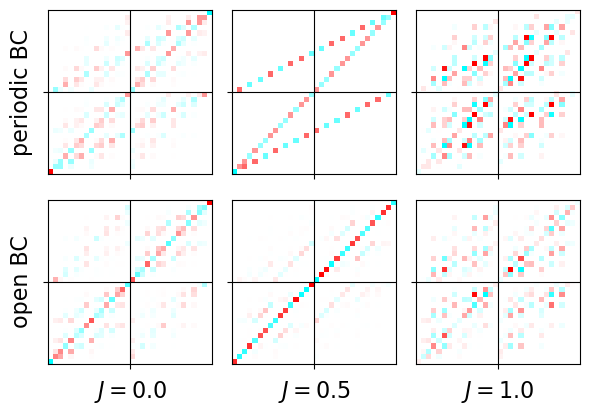

In [15]:
heis = sum([tensor([pauli] * 2) for pauli in [sigmax(), sigmay(), sigmaz()]])
heis2 = sum(
    [tensor([pauli, qeye(2), pauli])
     for pauli in [sigmax(), sigmay(), sigmaz()]]
)

N = 10
Js = [0.0, 0.5, 1.0]

fig = plt.figure(figsize=(2 * len(Js), 4.4))

for b in [0, 1]:
    for k, J in enumerate(Js):
        ax = plt.subplot(2, len(Js), b * len(Js) + k + 1)

        if b == 0:
            spinchain = spinchainize([heis, J * heis2], N, bc="periodic")
        elif b == 1:
            spinchain = spinchainize([heis, J * heis2], N, bc="open")

        plot_qubism(gs_of(spinchain), ax=ax)

        if k == 0:
            if b == 0:
                ax.set_ylabel("periodic BC", fontsize=16)
            else:
                ax.set_ylabel("open BC", fontsize=16)
        if b == 1:
            ax.set_xlabel("$J={0:.1f}$".format(J), fontsize=16)

plt.tight_layout()

We are not restricted to qubits. We can have it for other dimensions, e.g. qutrits.

Let us consider [AKLT model](http://en.wikipedia.org/wiki/AKLT_Model) for spin-1 particles:

$$H = \sum_{i=1}^N \vec{S}_i \cdot \vec{S}_{i+1} + \tfrac{1}{3} \sum_{i=1}^N (\vec{S}_i \cdot \vec{S}_{i+1})^2.$$

where $\vec{S}_i$ is [spin operator](http://en.wikipedia.org/wiki/Pauli_matrices#Physics) for spin-1 particles (or for `qutip`: `jmat(1, 'x')`, `jmat(1, 'y')` and `jmat(1, 'z')`).

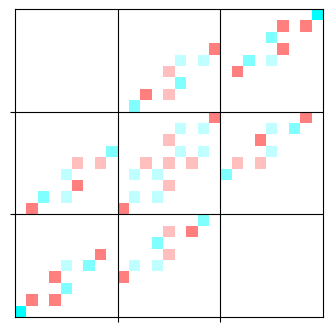

In [16]:
ss = sum([tensor([jmat(1, s)] * 2) for s in ["x", "y", "z"]])
H = spinchainize([ss, (1.0 / 3.0) * ss**2], n=6, bc="periodic")
plot_qubism(gs_of(H), figsize=(4, 4));

Qubism for qutrits works similarly as for qubits:

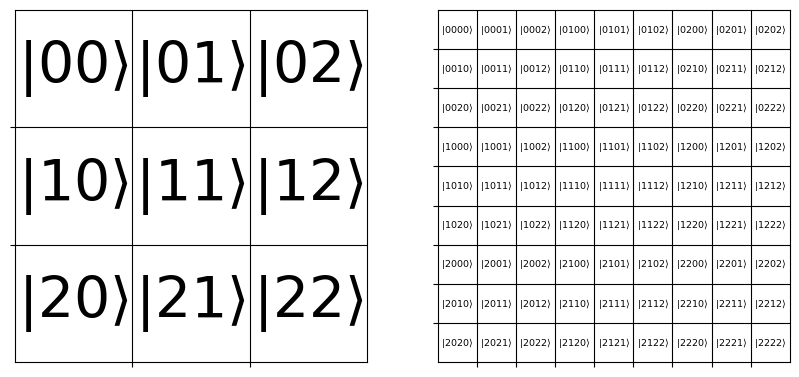

In [17]:
fig = plt.figure(figsize=(10, 5))
for i in [1, 2]:
    ax = plt.subplot(1, 2, i)
    plot_qubism(
        0 * ket("0000", dim=3), legend_iteration=i, grid_iteration=i,
        fig=fig, ax=ax
    )

Just in this case we interpret:

* 0 as $s_z=-1$,
* 1 as $s_z=\ \ 0$,
* 2 as $s_z=+1$.

While qubism works best for translationally-invariants states (so in particular, all particles need to have the same dimension), we can do it for others.

Also, there are a few other Qubism-related plotting schemes. For example `how='pairs_skewed'`:

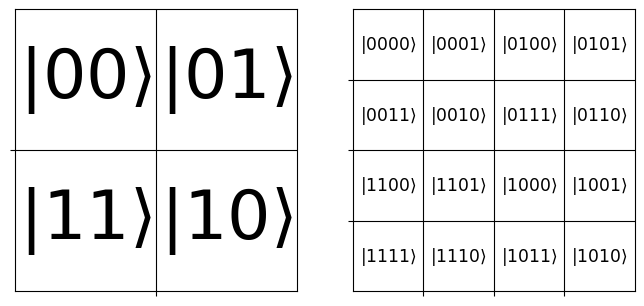

In [18]:
fig = plt.figure(figsize=(8, 4))
for i in [1, 2]:
    ax = plt.subplot(1, 2, i)
    plot_qubism(
        0 * ket("0000"),
        how="pairs_skewed",
        legend_iteration=i,
        grid_iteration=i,
        fig=fig,
        ax=ax,
    )

The one above emphasis ferromagnetic (put on the left) vs antiferromagnetic (put on the right) states.

Another one `how='before_after'` (inspired by [this](http://commons.wikimedia.org/wiki/File:Ising-tartan.png)) works in a bit different way: it uses typical recursion, but starting from middle particles. For example, the top left quadrant correspons to $|00\rangle_{N/2,N/2+1}$: 

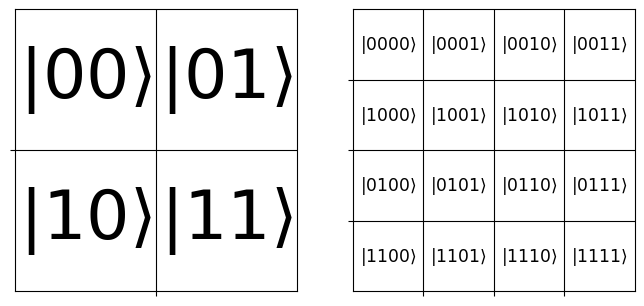

In [19]:
fig = plt.figure(figsize=(8, 4))
for i in [1, 2]:
    ax = plt.subplot(1, 2, i)
    plot_qubism(
        0 * ket("0000"),
        how="before_after",
        legend_iteration=i,
        grid_iteration=i,
        fig=fig,
        ax=ax,
    )

It is very similar to the Schmidt plot (for the default splitting), with the only difference being ordering of the `y` axis (particle order is reversed). All entanglement properties are the same.

So how does it work on the same example? 
Well, let us take spin chain for (Majumdar-Ghosh model for $J=0$), i.e.
$$H = \sum_{i=1}^N \vec{S}_i \cdot \vec{S}_{i+1}$$
for qubits.

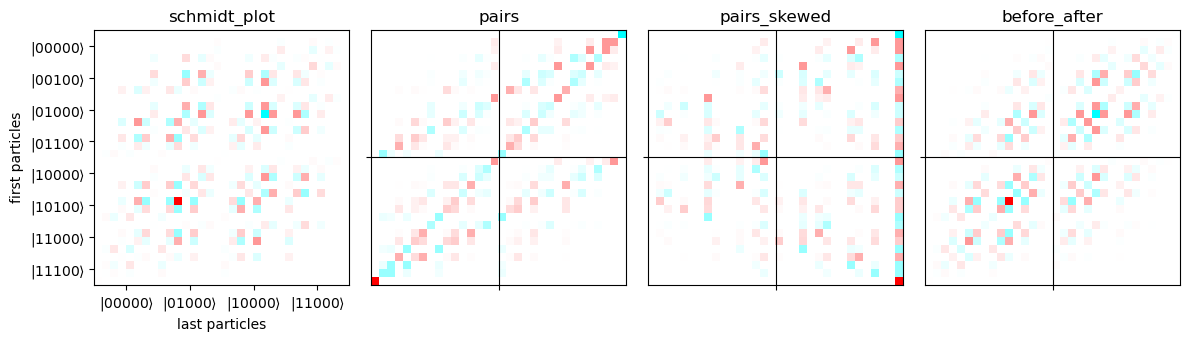

In [20]:
heis = sum([tensor([pauli] * 2) for pauli in [sigmax(), sigmay(), sigmaz()]])
N = 10
gs = gs_of(spinchainize(heis, N, bc="periodic"))

fig = plt.figure(figsize=(12, 4))
for i, how in enumerate(["schmidt_plot", "pairs",
                         "pairs_skewed", "before_after"]):
    ax = plt.subplot(1, 4, i + 1)
    if how == "schmidt_plot":
        plot_schmidt(gs, fig=fig, ax=ax)
    else:
        plot_qubism(gs, how=how, fig=fig, ax=ax)
    ax.set_title(how)
plt.tight_layout()

## Seeing entanglement

In [21]:
product_1 = ket("0000")
product_2 = tensor([(ket("0") + ket("1")).unit()] * 4)
w = (ket("0001") + ket("0010") + ket("0100") + ket("1000")).unit()
dicke_2of4 = (
    ket("0011") + ket("0101") + ket("0110") +
    ket("1001") + ket("1010") + ket("1100")
).unit()
ghz = (ket("0000") + ket("1111")).unit()

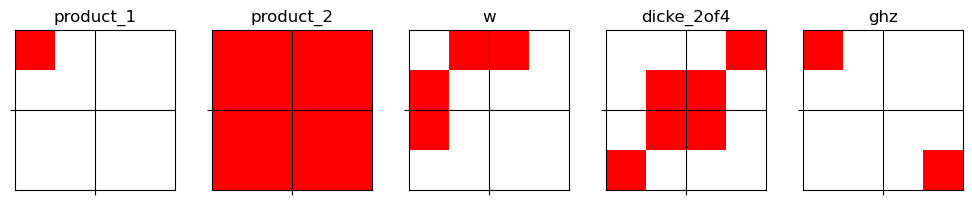

In [22]:
states = ["product_1", "product_2", "w", "dicke_2of4", "ghz"]
fig = plt.figure(figsize=(2 * len(states), 2))
for i, state_str in enumerate(states):
    ax = plt.subplot(1, len(states), i + 1)
    plot_qubism(eval(state_str), fig=fig, ax=ax)
    ax.set_title(state_str)
plt.tight_layout()

Then entanglement (or exactly: Schmidt rank) for a given partition is equal to number to different, non-zero squares. (We don't allow rotations, we do allow multiplication by a factor and, what may be more tricky, linear superposition.)

Here we use partition of first 2 particles vs last 2, as indicated by lines.

That is,
* `product_1` - only 1 non-zero square: Schmidt rank 1,
* `product_2` - 4 non-zero squares, but they are the same: Schmidt rank 1,
* `w` - 3 non-zero quares, but two of them are the same: Schmidt rank 2,
* `dicke_2of4` - 4 non-zero squares, but two of them are the same: Schmidt rank 3,
* `ghz` - 2 non-zero squares, each one different: Schmidt rank 2.

This is basis-independent, but it may be easier to work in one basis rather than another.

And for a comparision, let us see product states:

$$\left( \cos(\theta/2) |0\rangle + \sin(\theta/2) e^{i \varphi} |1\rangle \right)^N $$

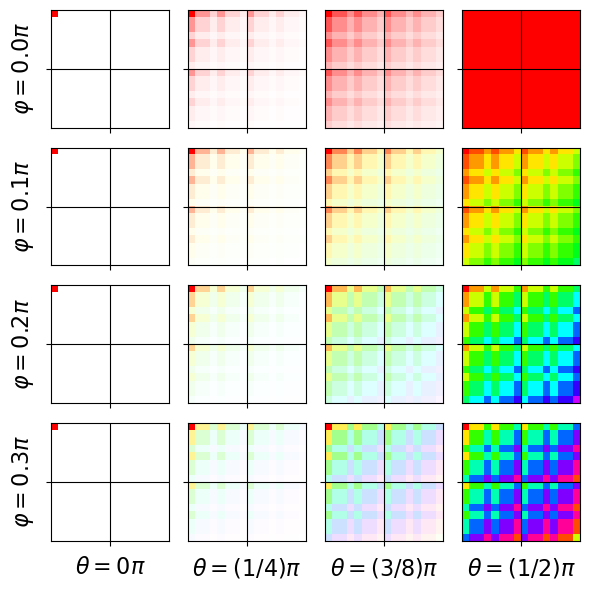

In [23]:
def product_state(theta, phi=0, n=1):
    single = Qobj([[np.cos(theta / 2.0)],
                   [np.sin(theta / 2.0) * np.exp(1j * phi)]])
    return tensor([single] * n)


thetas = 0.5 * np.pi * np.array([0.0, 0.5, 0.75, 1.0])
phis = np.pi * np.array([0.0, 0.1, 0.2, 0.3])

fig, axes2d = plt.subplots(nrows=len(phis),
                           ncols=len(thetas), figsize=(6, 6))

for i, row in enumerate(axes2d):
    for j, cell in enumerate(row):
        plot_qubism(
            product_state(thetas[j], phi=phis[i], n=8),
            grid_iteration=1, ax=cell
        )
        if i == len(axes2d) - 1:
            cell.set_xlabel(
                r"$\theta={0:s}\pi$".format(
                    ["0", "(1/4)", "(3/8)", "(1/2)"][j]),
                fontsize=16,
            )
        if j == 0:
            cell.set_ylabel(
                r"$\varphi={0:.1f}\pi$".format(phis[i] / np.pi), fontsize=16
            )

plt.tight_layout()

In each plot squares are the same, up to a factor (which is visualized as intensity and hue).

You can lookup previous plots. Setting `grid_iteration=2` would show splitting of the first 4 particles vs N-4 others.
And for `how='before_after'` it is the middle particles vs all others.

### Versions

In [24]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.1.dev0+c8dd6de
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.32
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can b